In [1]:
%matplotlib inline


# Multiway Cluster Robust DML

This example shows how the multiway cluster roboust DML (Chiang et al. 2020) can be implemented with the DoubleML
package.
Chiang et al. (2020) consider double-indexed data

\begin{equation}
\lbrace W_{ij}: i \in \lbrace 1, \ldots, N \rbrace, j \in \lbrace 1, \ldots, M \rbrace \rbrace
\end{equation}

and the partially linear IV regression model (PLIV)

$$\begin{aligned}
Y_{ij} = D_{ij} \theta_0 +  g_0(X_{ij}) + \epsilon_{ij}, & &\mathbb{E}(\epsilon_{ij} | X_{ij}, Z_{ij}) = 0, \\
Z_{ij} = m_0(X_{ij}) + v_{ij}, & &\mathbb{E}(v_{ij} | X_{ij}) = 0.
\end{aligned}$$

TODO: Add a few more details and the reference!
https://arxiv.org/pdf/1909.03489.pdf


In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

from sklearn.model_selection import KFold, RepeatedKFold
from sklearn.base import clone

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from doubleml import DoubleMLData, DoubleMLPLIV
from doubleml.double_ml_resampling import DoubleMLMultiwayResampling

from doubleml.datasets import make_pliv_multiway_cluster_CKMS2019

## Simulate multiway cluster data

We use the PLIV data generating process described in Section 4.1 of Chiang et al. (2020).



In [3]:
# Set the simulation parameters
N = 25  # number of observations (first dimension)
M = 25  # number of observations (second dimension)
dim_X = 100  # dimension of X

obj_dml_data = make_pliv_multiway_cluster_CKMS2019(N, M, dim_X)

In [4]:
# The data comes with multi index for rows (tuples with two entries)
obj_dml_data.data.head(30)

X1        X2        X3        X4        X5        X6        X7  \
0 0  -0.182721  0.116159  0.720507 -0.689334 -1.189473 -0.026766 -0.236250   
  1   0.292243 -0.153054 -0.248361  0.418510  0.310161 -0.072699 -0.310356   
  2   0.530476 -0.751669 -0.964794 -0.270282 -0.326192 -0.515830 -0.090546   
  3  -0.664460 -0.272737 -0.024632  1.011900 -0.268836  0.281400  0.241135   
  4  -0.221206 -0.849755  0.974935 -0.188853 -0.012258  0.560071  0.357546   
  5  -0.258909  0.388021  0.777444  1.147341 -0.885123 -0.333387  0.247030   
  6  -0.978475 -1.156970  0.101131 -1.344004 -1.524188  0.689753  0.608008   
  7   0.258485 -0.430647  0.399602  0.267560  0.705813  0.986042  0.690436   
  8  -0.329843  0.414081 -0.221885 -0.135633  0.124883 -0.032977  1.182194   
  9  -0.183065 -0.808562  0.416004  0.208414 -0.662270  0.217354  0.940702   
  10 -0.047037  0.047344  0.245996 -0.433743  0.717464 -0.191919 -0.043246   
  11  0.312241  1.065369  0.064307  0.450154 -0.563276 -0.181767  0.073132   
  12  0.391569 -0.148223 -0.494467  0.264049 -0.756632 -0.122550  0.186204   
  13 -0.007208  0.582249  1.225466  0.622179  1.087857  0.861283 -0.399771   
  14 -0.210910 -0.711745  0.198637  1.261253 -0.369618 -0.365387  0.331151   
  15 -0.515440  0.644859  0.620194 -0.054862 -0.636630  0.924401  0.587623   
  16 -0.308309  0.146341 -0.155751 -0.027732 -0.244633  0.872354  0.751867   
  17 -0.294963 -0.098765  1.012260  0.105497 -0.461581  0.444546  0.437454   
  18  0.531982  0.430318  0.900596 -0.233979 -0.810847 -1.026121  0.092891   
  19 -0.587238  0.230802  0.444794  0.845874  0.306688 -0.170090 -0.268591   
  20 -0.173616  0.978228  0.056656  0.122227  0.017501  0.442480  0.167891   
  21  0.256793  0.421593  0.335186  0.154910 -0.598181 -1.230873 -0.623658   
  22 -0.499039 -0.341100 -0.482689 -0.232000 -0.046289  0.480617 -0.192507   
  23  0.645550  0.989143  0.425245  0.220304  0.425613 -0.113813  0.018754   
  24 -0.304408 -0.478828 -0.152972  1.090559 -0.613374  0.358554 -0.912546   
1 0   0.148415  0.474999  0.156905 -0.037650 -0.323433 -0.254743 -0.859759   
  1   0.223819  0.954312  0.620111  0.402021 -0.289400 -0.184007  0.418260   
  2  -0.185466  0.412962 -1.368280  0.256412  0.944341  0.530515  0.237736   
  3  -0.539490  0.674823  0.049768  0.607703 -0.665378  0.605956 -0.094664   
  4  -1.193423  0.756270  0.118173  0.074735 -1.405634  0.291774  0.117083   

            X8        X9       X10  ...       X94       X95       X96  \
0 0  -0.912585  0.639364  0.680428  ... -0.391842  0.129083 -0.044501   
  1   0.172015  0.973293  0.463104  ... -0.360778  0.430338  0.244884   
  2  -0.204117  0.614630  0.682863  ... -0.287707  0.030538 -0.008864   
  3   0.184610 -0.087671 -0.127023  ... -0.051154  0.003356 -0.275853   
  4  -0.361255  0.301431  0.992458  ... -0.461325  0.027435  0.008928   
  5   0.225322  0.783096  0.063914  ...  0.004644  0.512550  0.115283   
  6   0.423427  0.548048 -0.840930  ...  0.171370  1.118414 -0.005248   
  7   1.012284  0.734478 -0.275632  ... -0.817674  0.326251 -0.503355   
  8   0.245336  0.526819 -0.100471  ...  0.838994 -0.315436 -0.214736   
  9   0.598256  2.104568  0.826756  ... -0.210193 -0.414069 -0.468799   
  10  0.513544  0.513929  0.785954  ...  0.220850  0.062259  0.006572   
  11  0.502831  1.295282 -0.045728  ... -0.221864 -0.857397 -0.994883   
  12  0.669474  0.323166  0.190561  ...  0.029039 -0.701672 -0.081133   
  13  0.678909  1.057466  1.386036  ... -0.055149  0.220704 -0.020043   
  14  0.338783  0.630749  0.002319  ... -0.210250  0.204723  0.026292   
  15  0.742510  0.986846  0.556383  ...  0.897633 -0.036307  1.444263   
  16  0.267442 -0.862009 -0.255121  ... -0.616870 -0.109415  0.073693   
  17 -0.066780 -0.015657  0.708676  ... -0.417848  0.448478 -0.223899   
  18  0.371331 -0.459536  0.132230  ...  0.398608 -0.192688  0.825050   
  19 -0.763966 -0.537730  0.345860  ...  0.398037  1.396245  0.065415   
  20  0.632615 -0.338378 -0.852221  ...  1.013317  0.239591 

## Initialize the objects of class DoubleMLData and DoubleMLPLIV



In [5]:
# Set machine learning methods for m & g
learner = RandomForestRegressor(max_depth=2, n_estimators=10)
ml_g = clone(learner)
ml_m = clone(learner)
ml_r = clone(learner)

# initialize the DoubleMLPLIV object
dml_pliv_obj = DoubleMLPLIV(obj_dml_data,
                            ml_g,
                            ml_m,
                            ml_r,
                            score='partialling out',
                            dml_procedure='dml1',
                            draw_sample_splitting=False)

## Split samples and transfer the sample splitting to the object



In [6]:
K = 3  # number of folds
smpl_sizes = [N, M]
obj_dml_multiway_resampling = DoubleMLMultiwayResampling(K, smpl_sizes)
smpls_multi_ind, smpls_lin_ind = obj_dml_multiway_resampling.split_samples()

dml_pliv_obj.set_sample_splitting([smpls_lin_ind])

## Fit the model and show a summary



In [7]:
dml_pliv_obj.fit()
print(dml_pliv_obj.summary)

       coef   std err          t          P>|t|     2.5 %   97.5 %
D  1.071882  0.036969  28.993964  7.839774e-185  0.999424  1.14434


## Visualization of sample splitting with tuple and linear indexing



In [8]:
#discrete color scheme
x = sns.color_palette("RdBu_r", 7)
cMap = ListedColormap([x[0], x[3], x[6]])
plt.rcParams['figure.figsize'] = 15, 12
sns.set(font_scale=1.3)

### Visualize sample splitting with tuples (one plot per fold)



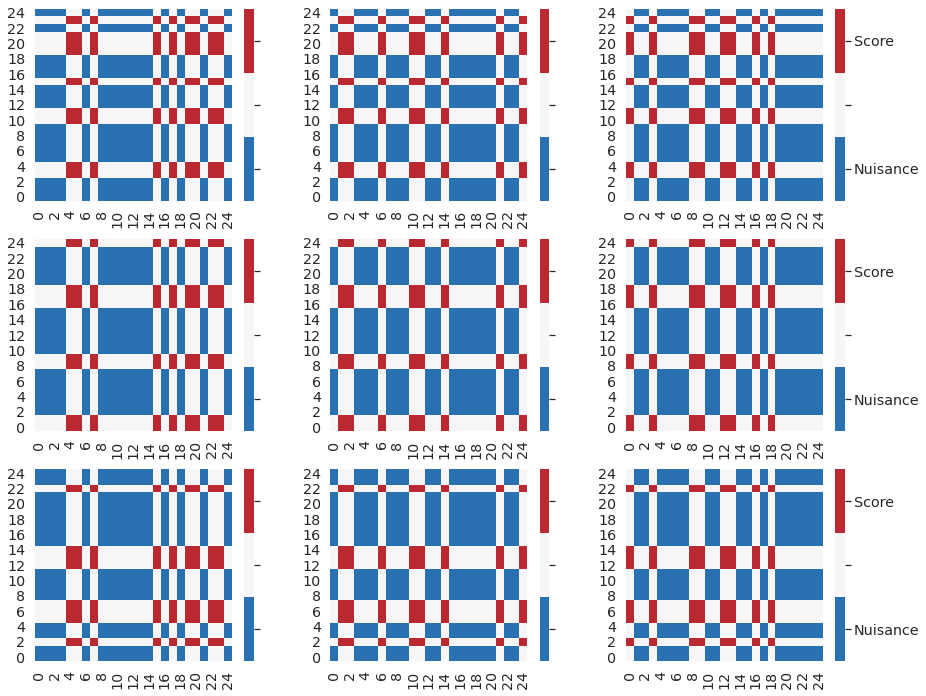

In [9]:
for i_split, this_split_ind in enumerate(smpls_multi_ind):
    plt.subplot(K, K, i_split + 1)
    df = pd.DataFrame(np.zeros([N, M]))
    ind_array_train = np.array([*this_split_ind[0]])
    ind_array_test = np.array([*this_split_ind[1]])
    df.loc[ind_array_train[:, 0], ind_array_train[:, 1]] = -1.
    df.loc[ind_array_test[:, 0], ind_array_test[:, 1]] = 1.

    ax = sns.heatmap(df, cmap=cMap);
    ax.invert_yaxis();
    ax.set_ylim([0, M]);
    colorbar = ax.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if i_split % K == (K - 1):
        colorbar.set_ticklabels(['Nuisance', '', 'Score'])
    else:
        colorbar.set_ticklabels(['', '', ''])

### Visualize sample splitting with linear indexing (one column per fold)



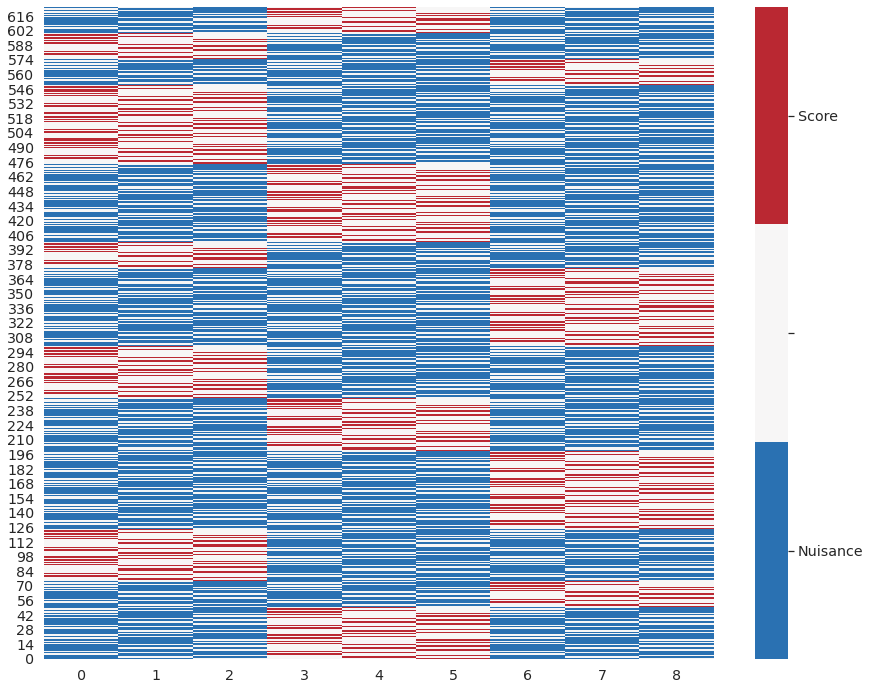

In [10]:
df = pd.DataFrame(np.zeros([N*M, K*K]))
for i_split, this_split_ind in enumerate(smpls_lin_ind):
    df.loc[this_split_ind[0], i_split] = -1.
    df.loc[this_split_ind[1], i_split] = 1.

ax = sns.heatmap(df, cmap=cMap);
ax.invert_yaxis();
ax.set_ylim([0, N*M]);
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['Nuisance', '', 'Score'])